- 422001503002_1_71_21018541_Nguyễn Chiêu Văn
- Lớp: 422001503002
- Ca 1 (1: sáng, 2: chiều)
- STT: 71
- MSSV: 21018541
- Họ tên: Nguyễn Chiêu Văn

## Library setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from tqdm import tqdm
from collections import Counter

# Data and Pre-processing

In [2]:
# Path to the images
images_directory = '/kaggle/input/d/eeshawn/flickr30k/flickr30k_images'
# Path to the captions
captions_path = '/kaggle/input/d/eeshawn/flickr30k/captions.txt'

In [3]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer(num_words= 15000, oov_token="<OOV>")
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

['1000092795.jpg,0,two young guys with shaggy hair look at their hands while hanging out in the yard .\n',
 '1000092795.jpg,3,a man in a blue shirt standing in a garden .\n',
 '10002456.jpg,1,workers look down from up above on a piece of equipment .\n',
 '10002456.jpg,4,three men on a large rig .\n',
 '1000268201.jpg,2,a little girl climbing the stairs to her playhouse .\n']

## Cleaning the captions

In [4]:
import re

def clean(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Ensure the text doesn't exceed the max length
    words = text.split()    
    return 'startseq '+ text + ' endseq'
cleaned_cap = [clean(caption.split(',')[2]) for caption in captions]

In [5]:
import re

def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Ensure the text doesn't exceed the max length
    words = text.split()
    if len(words) > 40:
        text = ' '.join(words[:40])  # Keep only the first 35 words
    
    return 'startseq '+ text + ' endseq'

# Cleaning the captions and limiting the length to 35
cleaned_captions = [clean_text(caption.split(',')[2]) for caption in captions]
cleaned_captions[:15:2]  

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two men in green shirts are standing in a yard endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq workers look down from up above on a piece of equipment endseq',
 'startseq four men on top of a tall structure endseq',
 'startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a girl going into a wooden building endseq']

In [6]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t' +cleaned_captions[i]+'\n'
    captions_IDs.append(item)
    
captions_IDs[:20:3], len(captions_IDs)

(['1000092795.jpg\tstartseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq\n',
  '1000092795.jpg\tstartseq a man in a blue shirt standing in a garden endseq\n',
  '10002456.jpg\tstartseq workers look down from up above on a piece of equipment endseq\n',
  '10002456.jpg\tstartseq three men on a large rig endseq\n',
  '1000268201.jpg\tstartseq a little girl climbing the stairs to her playhouse endseq\n',
  '1000344755.jpg\tstartseq someone in a blue shirt and hat is standing on stair and leaning against a window endseq\n',
  '1000344755.jpg\tstartseq man in blue shirt and jeans on ladder cleaning windows endseq\n'],
 158915)

## Visualizing some of the images along with their corresponding captions

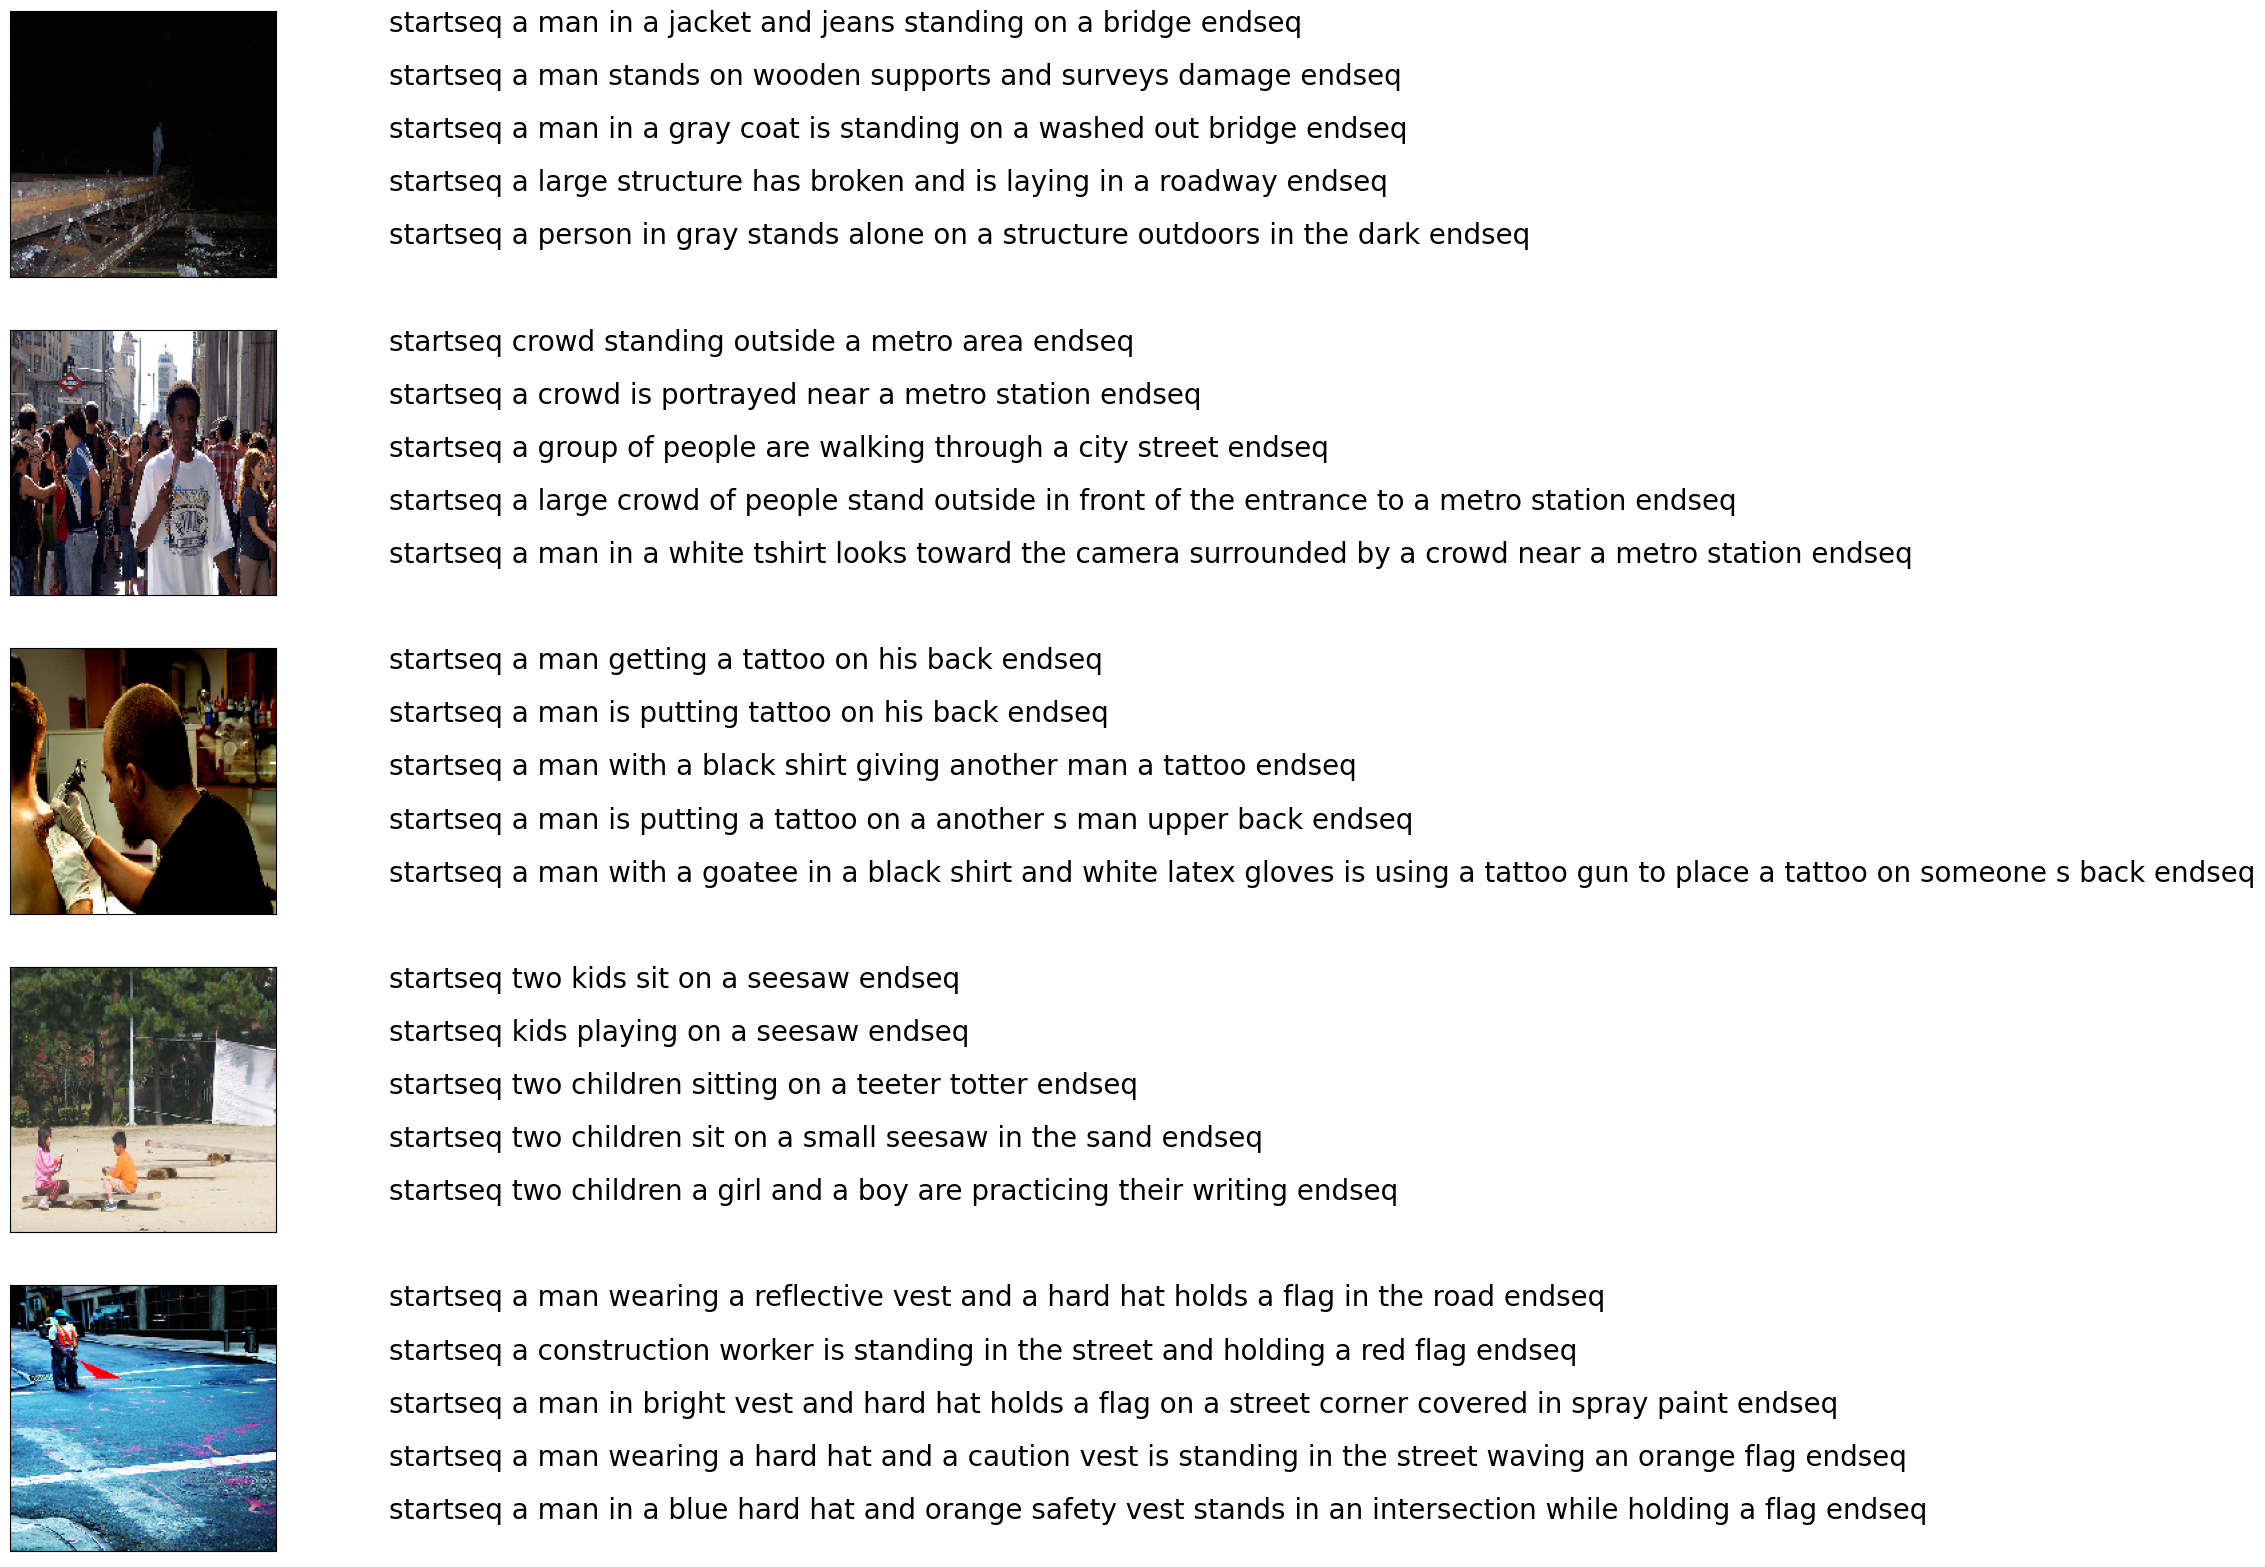

In [7]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+ "/"+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(captions_IDs, 5)

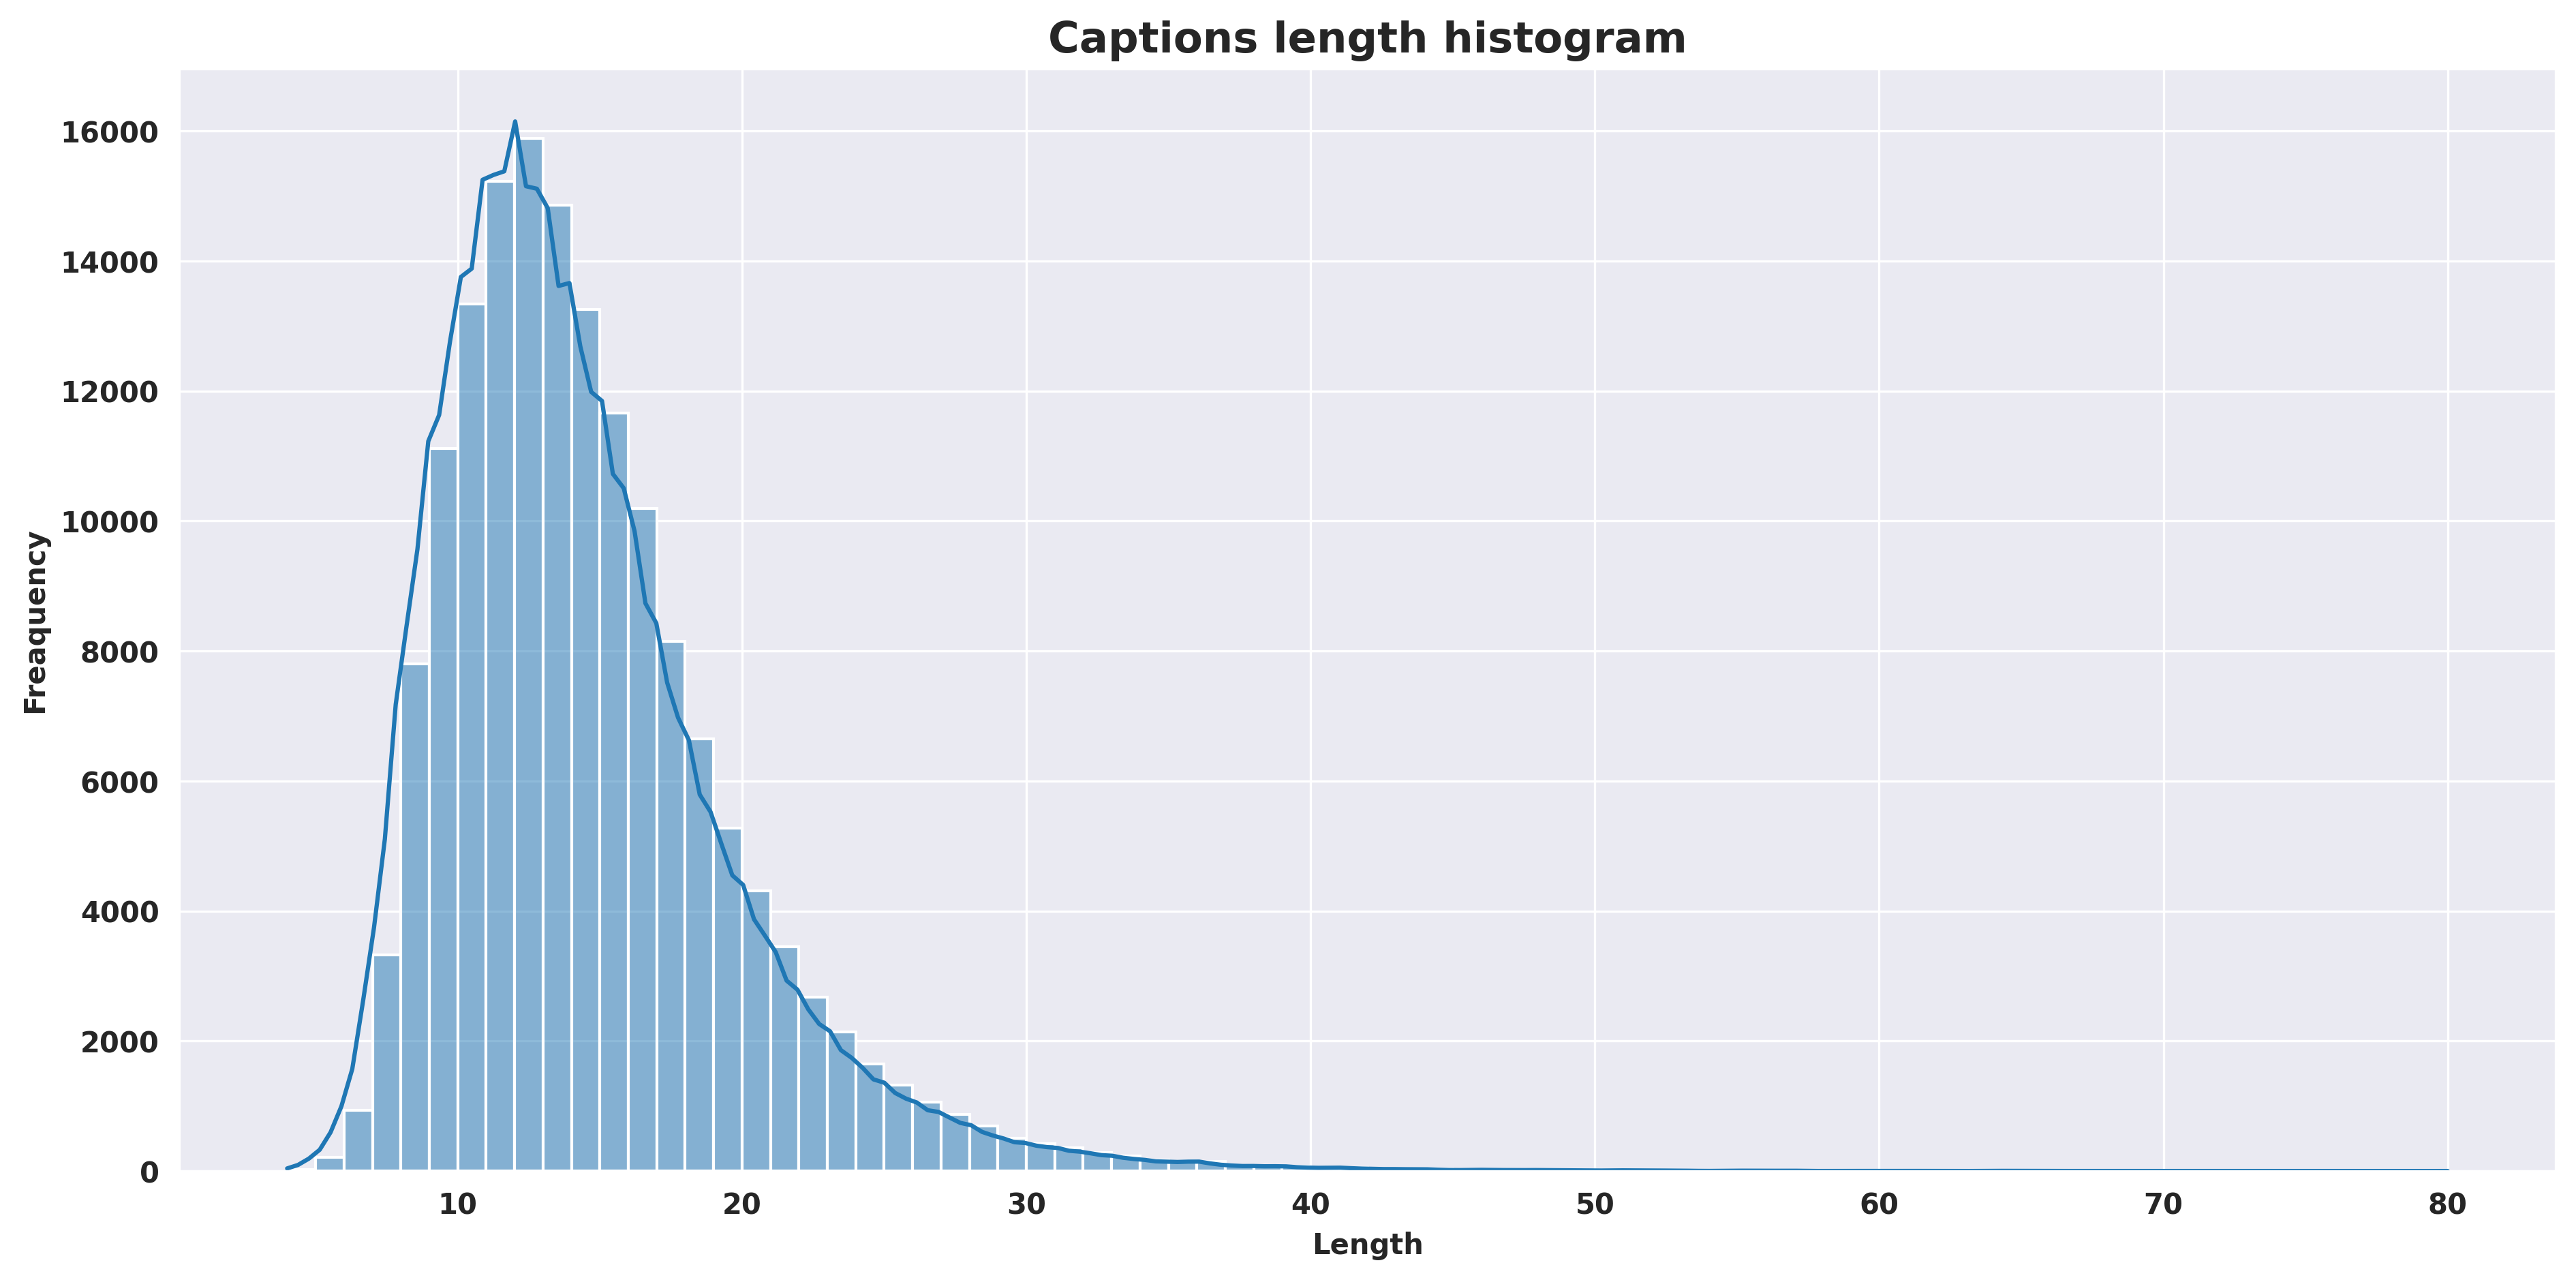

In [8]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
captions_length(cleaned_cap)

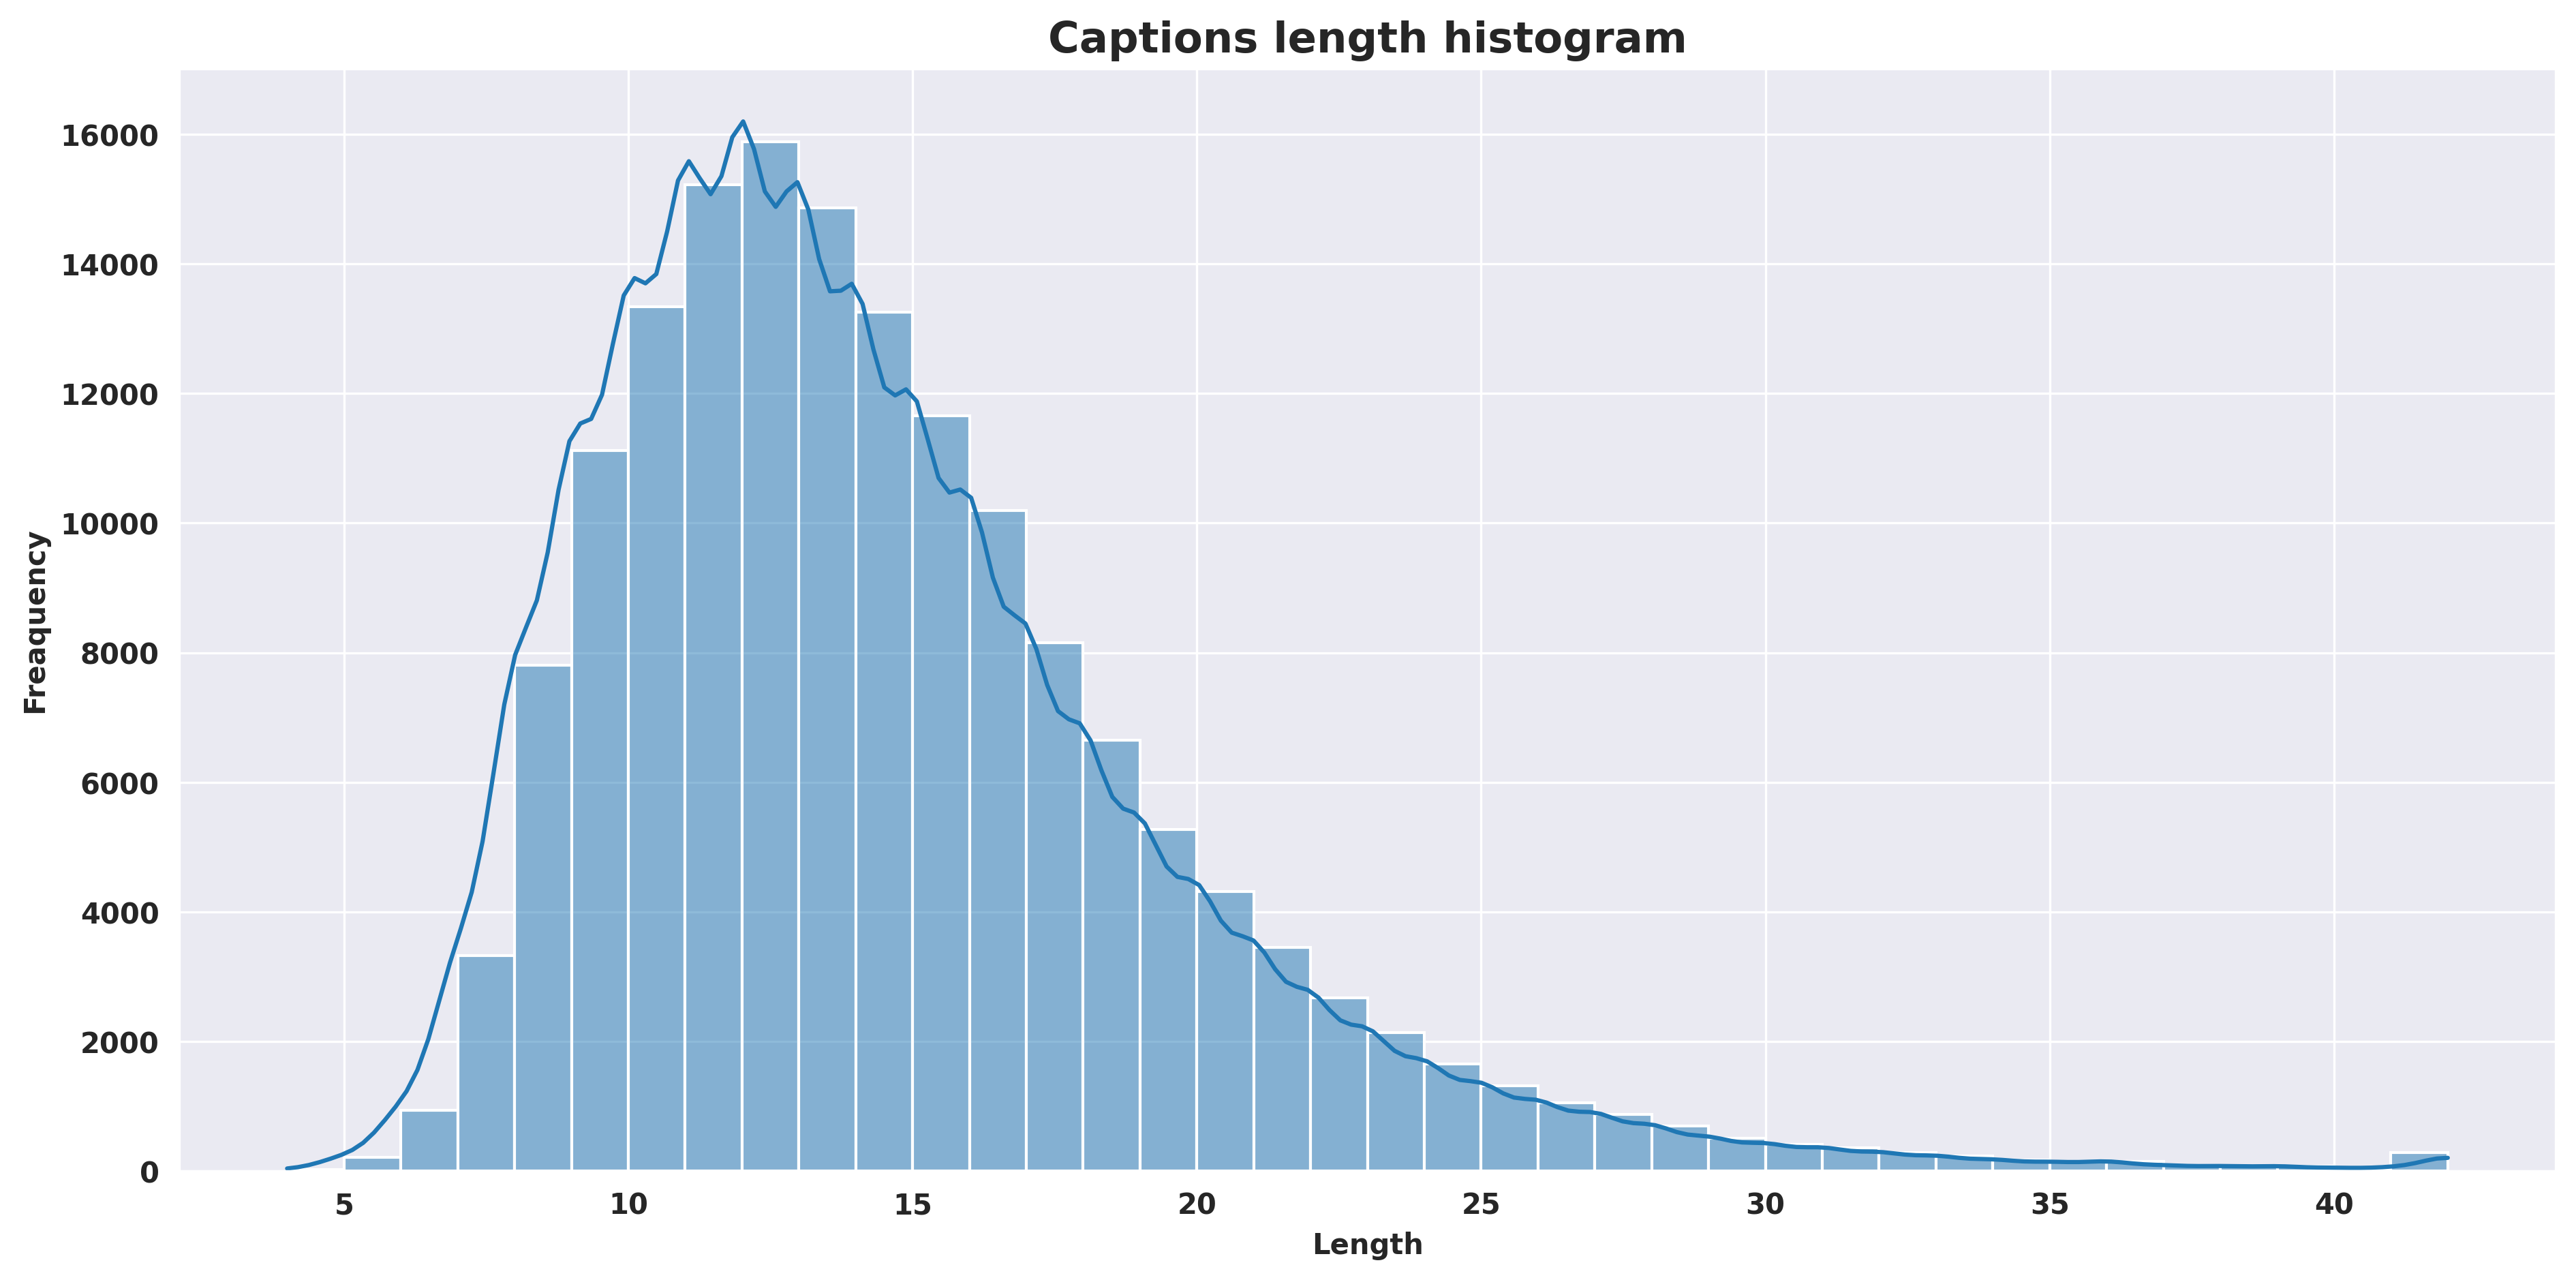

In [9]:
captions_length(cleaned_captions)

In [10]:
import numpy as np
from collections import Counter
import plotly.graph_objects as go

def word_occurrences(data):
    # Combining all sentences into a single string
    all_text = ' '.join(data)
    
    # Split text and remove 'a' before counting
    words = all_text.split()
    words = [word for word in words]
    
    # Counting occurrences
    word_counts = Counter(words)

    # Get top 30 most common words
    words = list(word_counts.keys())[:30]
    values = list(word_counts.values())[:30]

    # Normalize values to be between 0 and 1
    normalized_values = np.array(values) / np.max(values)
    
    # Generate color scale based on occurrences
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * value) for value in normalized_values])

    # Plot using Plotly
    fig = go.Figure(data=[go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label')])

    fig.update_layout(title_text='Word occurrences in captions (excluding letter "a")', title_font=dict(size=23, family='Balto'))

    fig.show()

# Assuming 'cleaned_captions' is your data
word_occurrences(cleaned_captions)


### **Tokenizing** captions and setting **vocab size**

In [11]:
# Tokenizing the captions and creating word-to-index mapping
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

19769

In [ ]:
import pickle

# Giả sử bạn có tokenizer đã fit rồi
with open('tokenizer_flick30k.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
import pickle

with open('tokenizer_flick30k.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

### Splitting the data into tain, validation and test sets

In [12]:
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    
    if image_id in train_image_ids:
        train_captions.append(caption)
        
    elif image_id in val_image_ids:
        val_captions.append(caption)        

    elif image_id in test_image_ids:
        test_captions.append(caption)
        
    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000092795.jpg\tstartseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq\n',
 '10010052.jpg\tstartseq a girl is on rollerskates talking on her cellphone standing in a parking lot endseq\n',
 '1000344755.jpg\tstartseq someone in a blue shirt and hat is standing on stair and leaning against a window endseq\n',
 27015.0,
 4291.0,
 477.0)

## **Extracting Image features** using **The InceptionV3** model

In [13]:
resnet50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))

# Loại bỏ lớp cuối cùng
resnet50_model.layers.pop()

# Tạo một mô hình mới mà chỉ giữ lại các lớp trước lớp cuối cùng
resnet50_model = Model(inputs=resnet50_model.inputs, outputs=resnet50_model.layers[-2].output)

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
from collections import defaultdict
from tqdm import tqdm
import os
import numpy as np
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

# Sử dụng defaultdict để giảm việc kiểm tra tồn tại trong từ điển
train_image_features, val_image_features, test_image_features = {},{},{}

# Tạo danh sách tất cả ảnh trong thư mục
all_image_ids = os.listdir(images_directory)

# Hàm trích xuất đặc trưng ảnh cho một batch
def extract_image_features_batch(model, image_paths, batch_size=32):
    batch_features = []
    batch_images = []
    
    for image_path in image_paths:
        image = load_img(image_path, target_size=(224, 224))  # Dùng kích thước phù hợp với InceptionV3
        image = img_to_array(image)
        image = preprocess_input(image)  # Chuẩn hóa ảnh trước khi đưa vào model
        batch_images.append(image)

        # Khi đủ batch_size, thực hiện predict
        if len(batch_images) == batch_size:
            batch_images_np = np.array(batch_images)
            features = model.predict(batch_images_np)  # Dự đoán cho batch
            batch_features.append(features)
            batch_images = []  # Reset batch_images

    # Nếu còn ảnh chưa đủ batch_size, xử lý tiếp
    if batch_images:
        batch_images_np = np.array(batch_images)
        features = model.predict(batch_images_np)
        batch_features.append(features)
    
    return np.vstack(batch_features)  # Trả về tất cả đặc trưng của ảnh

# Hàm xử lý ảnh theo batch
def process_images_with_batch(image_ids, batch_size=32):
    all_image_ids = os.listdir(images_directory)  # Lấy tất cả ảnh trong thư mục
    pbar = tqdm(total=len(all_image_ids)//batch_size, position=0, leave=True, colour='green',)

    for i in range(0, len(all_image_ids), batch_size):
        batch_paths = all_image_ids[i:i+batch_size]  # Chia ảnh thành các batch
        batch_paths_full = [os.path.join(images_directory, path) for path in batch_paths]  # Đường dẫn đầy đủ

        # Trích xuất đặc trưng cho batch ảnh
        batch_features = extract_image_features_batch(resnet50_model, batch_paths_full, batch_size)
        
        # Gán đặc trưng vào các nhóm ảnh
        for j, image_path in enumerate(batch_paths):
            image_id = os.path.basename(image_path)  # Lấy ID của ảnh từ tên file
            if image_id in train_image_ids:
                train_image_features[image_id] = batch_features[j]
            elif image_id in val_image_ids:
                val_image_features[image_id] = batch_features[j]
            elif image_id in test_image_ids:
                test_image_features[image_id] = batch_features[j]
            else:
                print(f"Unknown image ID: {image_id}")
        
        pbar.update(batch_size)
    
    pbar.close()

# Gọi hàm với batch_size 32
process_images_with_batch(image_ids=all_image_ids, batch_size=32)

# Kiểm tra kết quả
print(f"Number of train images processed: {len(train_image_features)}")
print(f"Number of validation images processed: {len(val_image_features)}")
print(f"Number of test images processed: {len(test_image_features)}")


# **Data Setup for Model Input**
> #### To **optimize** memory usage, it's suggested to use **generators** to collect the data

In [15]:
resnet50_model.output_shape[1] # 2048

2048

In [16]:
# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1
# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = resnet50_model.output_shape[1] # 2048

# Defining batch size
batch_size_train = 270
batch_size_val = 150

In [17]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size, vocab_size):
    num_samples = len(captions)
    while True:
        np.random.shuffle(captions)
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.strip()
                if image_id not in image_features:
                    continue

                seq = tokenizer.texts_to_sequences([caption_text])[0]

                # Nhập và xuất chuỗi đầy đủ cho training
                in_seq = seq[:-1]
                out_seq = seq[1:]
    
                in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]
                out_seq = pad_sequences([out_seq], maxlen=max_caption_length, padding='post')[0]
                out_seq = to_categorical(out_seq, num_classes=vocab_size)  # shape: (max_len, vocab_size)

                X_images.append(image_features[image_id])
                X_captions.append(in_seq)
                y.append(out_seq)

            yield (
                (np.array(X_images, dtype=np.float32), np.array(X_captions, dtype=np.int32)),
                np.array(y, dtype=np.float32)  # shape: (batch, max_len, vocab_size)
            )

# **Defining** the **Image Captioning** Model

> ### **Encoder** (image features)
> * Input Layer
> * Batch Normalization Layer
> * Dense Layer
> * Batch Normalization Layer

> ### **Decoder** (captions)
> * Input Layer
> * Embedding Layer
> * **LSTM** Layer

> ### **Output**
> * Add Layer (Encoder output + Decoder output)
> * Dense Layer + ReLU activation function
> * Dense Layer + Softmax activation function

In [22]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, MultiHeadAttention, BatchNormalization, RepeatVector, Concatenate, Dropout
from tensorflow.keras.models import Model

def build_model(vocab_size, max_caption_length, cnn_output_dim=2048):
    # === ENCODER ===
    input_image = Input(shape=(cnn_output_dim,), name='Image_Input')  # (2048,)
    x = Dense(256, activation='relu')(input_image)
    image_seq = RepeatVector(49)(x)  # Giả lập 49 vùng ảnh: (batch, 49, 256)

    # === DECODER ===
    input_caption = Input(shape=(max_caption_length,), name='Caption_Input')
    embedded = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(input_caption)
    lstm_out = LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(embedded)

    # === MULTI-HEAD ATTENTION ===
    attn_out = MultiHeadAttention(num_heads=4, key_dim=256)(
        query=lstm_out, key=image_seq, value=image_seq
    )

    # === MERGE + OUTPUT ===
    merged = Concatenate()([lstm_out, attn_out])  # (batch, max_len, 512)
    dense = Dense(512, activation='relu')(merged)
    dense = BatchNormalization()(dense)
    dropout = Dropout(0.3)(dense)
    outputs = Dense(vocab_size, activation='softmax')(dropout)  # (batch, max_len, vocab_size)

    model = Model(inputs=[input_image, input_caption], outputs=outputs)
    return model

In [21]:
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)
plot_model(caption_model)

NameError: name 'build_model' is not defined

# Training the model
##### **Training** will **stop** if there is **no improvement** in the **validation loss** for **3 consecutive epochs**.

In [25]:
from tensorflow.keras.optimizers import Adam


# caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

# caption_model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
#     metrics=['accuracy']
# )

# Dataset
train_gen = lambda: data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train, vocab_size)
val_gen = lambda: data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val, vocab_size)

output_signature = (
    (
        tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
        tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(None, max_caption_length, vocab_size), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(train_gen, output_signature=output_signature)
val_dataset = tf.data.Dataset.from_generator(val_gen, output_signature=output_signature)


In [27]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.6))

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(
    train_dataset,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_dataset,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=1,
    callbacks=[early_stopping, lr_schedule]
)


500/500 [==============================] - 728s 1s/step - loss: 3.0501 - accuracy: 0.3829 - val_loss: 3.2327 - val_accuracy: 0.3750 - lr: 6.7729e-08


In [28]:
# Lưu model
caption_model.save('caption_model_flick30k_2.keras')

# Tải model
# from tensorflow.keras.models import load_model
# caption_model = load_model('/kaggle/input/weight-flick30k/caption_model_flick30k.keras')

### Visualizing the model performance

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

# Inference
> ##### **Caption Generation:** At **each time step**, **the model takes** as input **the image features** along with **the generated words** (starting with start at the first time step), **predicting the probabilities** of **the next word**.
> ##### **Greedy algorithm:** To select  **the best caption**, **the greedy algorithm** is employed. This method, chooses **the most probable word** at each time step and **appends it** to the generated captions **until** the selected word is the **end** token, **or the length** of the decoded captions exceeds  **the maximum sequence length**.
> ##### **Beam Search:** Beam Search is an **alternative** to the greedy algorithm for **selecting captions**. It **maintains** a beam of **multiple hypotheses** (candidate captions) at each time step. At each step, **the model predicts** the next word for **each hypothesis**. **The top-k candidates** (based on probabilities) **are retained** in the beam. The process **continues until** the **end token** is generated **or the maximum sequence length** is reached.
> ##### **Evaluation** is performed using the **BLEU score**
> ##### **Visualization:** The function visualization() plots the **images along with their corresponding predicted captions, accompanied by 2 BLEU scores**.

In [ ]:
def generate_caption(model, tokenizer, image_feature, max_caption_length):
    start_token_idx = tokenizer.word_index['startseq']
    end_token_idx = tokenizer.word_index['endseq']
    
    caption_seq = [start_token_idx]
    
    for _ in range(max_caption_length):
        input_seq = np.zeros((1, max_caption_length), dtype=np.int32)
        input_seq[0, :len(caption_seq)] = caption_seq
        
        preds = model.predict([image_feature[np.newaxis, :], input_seq], verbose=0)
        next_token_probs = preds[0, len(caption_seq)-1]
        next_token = np.argmax(next_token_probs)
        
        if next_token == end_token_idx:
            break
        
        caption_seq.append(next_token)
    
    caption_words = []
    for idx in caption_seq[1:]:  # bỏ token startseq
        word = tokenizer.index_word.get(idx, '')
        if word == '':
            break
        caption_words.append(word)
    
    return ' '.join(caption_words)


In [ ]:
generate_caption(caption_model,tokenizer,image_feature,max_caption_length)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Dự đoán câu
y_pred = 'a group of people are walking down a street'

# Danh sách các câu tham khảo (có thể nhiều câu tham khảo cho một mẫu)
captions = ['a group of people hello how are you']

actual = []
predicted = []

# Ở đây giả sử mỗi mẫu có 1 câu tham khảo
actual.append([captions[0].split()])
predicted.append(y_pred.split())

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


# **Happy coding!**

# Load Model

In [1]:
from tensorflow.keras.applications import ResNet50
from collections import defaultdict
from tqdm import tqdm
import os
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
import pickle
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with open('/kaggle/input/weight-flick30k/tokenizer_flick30k.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [3]:
resnet50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))

# Loại bỏ lớp cuối cùng
resnet50_model.layers.pop()

# Tạo một mô hình mới mà chỉ giữ lại các lớp trước lớp cuối cùng
resnet50_model = Model(inputs=resnet50_model.inputs, outputs=resnet50_model.layers[-2].output)

102967424/102967424 [==============================] - 4s 0us/step


In [4]:
caption_model = load_model('/kaggle/input/weight-2/caption_model_flick30k_2.keras')
caption_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Caption_Input (InputLayer)     [(None, 43)]         0           []                               
                                                                                                  
 Image_Input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 43, 256)      5060864     ['Caption_Input[0][0]']          
                                                                                                  
 dense_9 (Dense)                (None, 256)          524544      ['Image_Input[0][0]']            
                                                                                            

In [ ]:
# train_image_features['2715746315.jpg'].shape

In [5]:
def get_featue_img_path(img_path):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    images_np = np.array(image)
    images_np = np.expand_dims(images_np, axis=0)
    features = resnet50_model.predict(images_np)
    return features

In [15]:
image_path = "/kaggle/input/datata/601/000000000885.jpg"
im = get_featue_img_path(image_path)
image_feature = im.squeeze(axis=0)

1/1 [==============================] - 0s 24ms/step


In [7]:
max_caption_length = 43
def generate_caption(model, tokenizer, image_feature, max_caption_length):
    start_token_idx = tokenizer.word_index['startseq']
    end_token_idx = tokenizer.word_index['endseq']
    
    caption_seq = [start_token_idx]
    
    for _ in range(max_caption_length):
        input_seq = np.zeros((1, max_caption_length), dtype=np.int32)
        input_seq[0, :len(caption_seq)] = caption_seq
        
        preds = model.predict([image_feature[np.newaxis, :], input_seq], verbose=0)
        next_token_probs = preds[0, len(caption_seq)-1]
        next_token = np.argmax(next_token_probs)
        
        if next_token == end_token_idx:
            break
        
        caption_seq.append(next_token)
    
    caption_words = []
    for idx in caption_seq[1:]:  # bỏ token startseq
        word = tokenizer.index_word.get(idx, '')
        if word == '':
            break
        caption_words.append(word)
    
    return ' '.join(caption_words)

# Kết quả

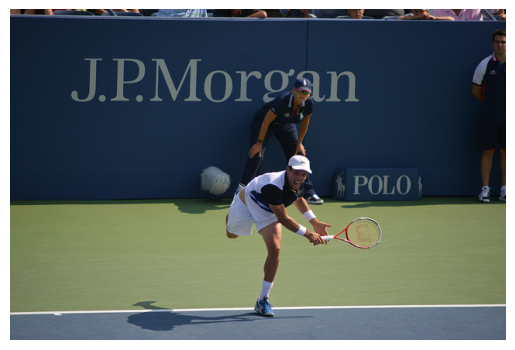

In [16]:
img = Image.open(image_path)

# Hiển thị ảnh với matplotlib
plt.imshow(img)
plt.axis('off')  # Tắt trục
plt.show()

In [17]:
y_pred = generate_caption(caption_model,tokenizer, image_feature ,max_caption_length)
y_pred

'a man in a white shirt is playing tennis'

In [22]:
# Dự đoán câu
y_pred = 'a man in a blue shirt is walking down a street'

# Danh sách các câu tham khảo (có thể nhiều câu tham khảo cho một mẫu)
captions = ['a male tennis player in white shorts is playing tennis']

actual = []
predicted = []

# Ở đây giả sử mỗi mẫu có 1 câu tham khảo
actual.append([captions[0].split()])
predicted.append(y_pred.split())

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.272727
BLEU-2: 0.522233
BLEU-3: 0.651314
BLEU-4: 0.722657


Mô hình gồm bao nhiêu khối chức năng (functional blocks)? ví dụ: 2
Em đùng kaaggle nên không biết khối và dòng, nên em chụp ở phía trên

Khối 1:
* Nhiệm vụ: ví dụ: chuyển ảnh đầu vào thành vector đặc trưng có nghĩa (mục tiêu của khối chức năng tương ứng)
* - Encoder Ảnh để làm đầu vào cho model trích xuất đặc trưng
  - 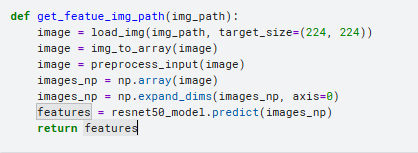
* Vị trí code: ví dụ: cell 10, dòng 30-60 (cell code, dòng code bắt đầu-dòng code kết thúc, tuân theo “line numbers” trên google colab)
* Input: ví dụ:  ma trận ảnh (thông tin đầu vào của khối)  m trận ảnh được rezie về 224 224, chuẩn hóa 0 - 1
* Output: ví dụ: vector đặc trưng (thông tin đầu ra của khối) , tạo ra vector (1,2048)

Khối 2: 
* Nhiệm vụ: tạo đầu vào cho model, chuyển text về số, chuẩn hóa đầu vào cho model
* Vị trí code: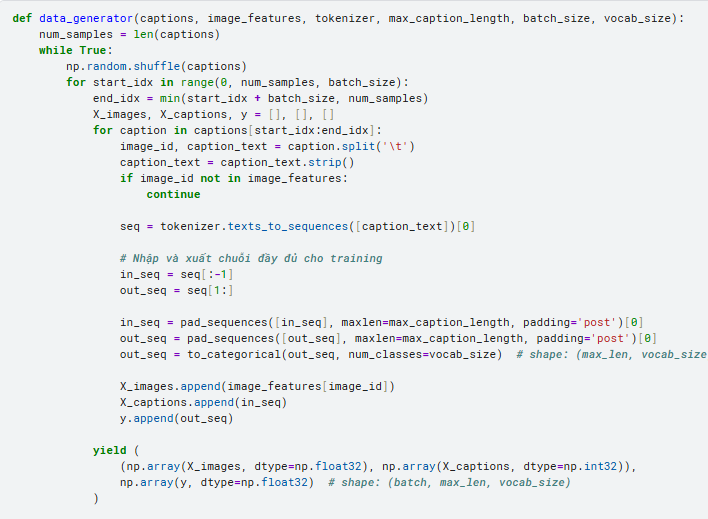
* Input:
* Output:

Khối 3:
* Nhiệm vụ: chuyển đầu ra về số về chữ
* Vị trí code: 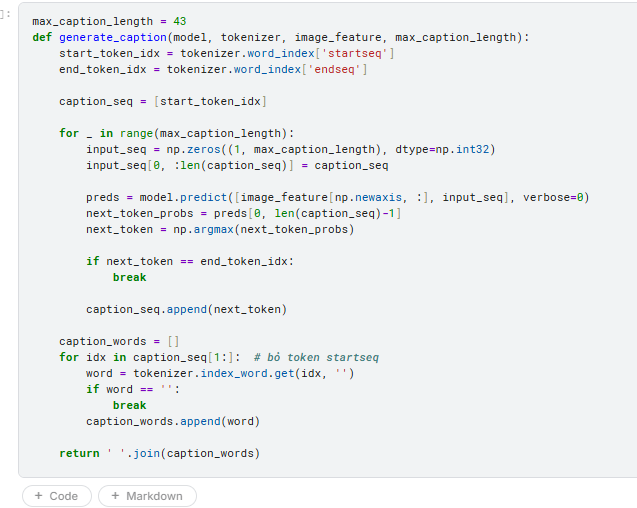
* Input:
* Output:

Khối 4:
* Nhiệm vụ: Đánh giá kết quả của model có chính xác không
* Vị trí code: 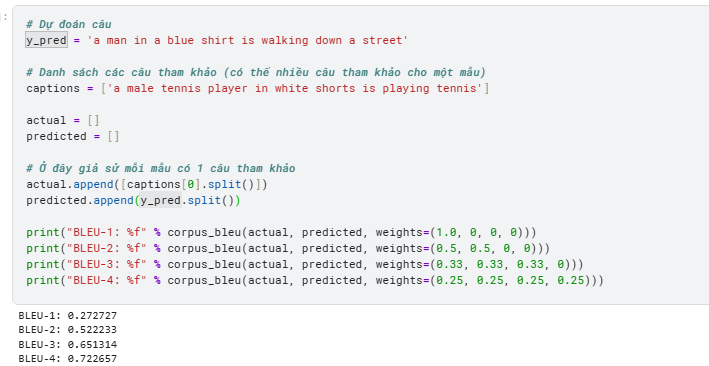
* Input:
* Output:

…
Khối 5: mô đồ
- 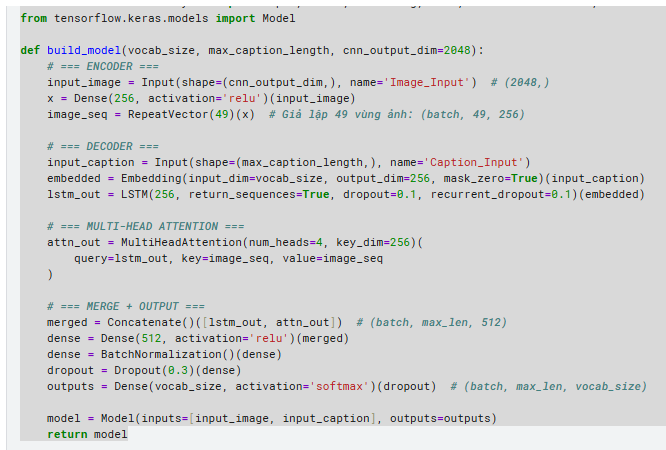
- Gồm các khối lstm_3 (LSTM) :đẻ mô hình xử lí với dữ liệu chuôi
- Khối Attention đùng để gép aanh và text